In [90]:
'''
Library needed
'''
import numpy as np
import pandas as pd

from skimage import io, transform
from skimage.transform import AffineTransform, warp

import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D,BatchNormalization,Activation,MaxPooling2D,Conv2DTranspose,concatenate, Input,UpSampling2D, Dropout
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from keras.callbacks import ModelCheckpoint

import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [91]:
'''
Image shape
'''
original_img_width = 1918
original_img_height = 1280
resized_img_width = 256
resized_img_height = 256
input_shape = (resized_img_width, resized_img_height, 3)
mask_shape = (resized_img_width, resized_img_height)
resized_image_size = (resized_img_width, resized_img_height)
original_image_size = (original_img_width,original_img_height)
output_shape = (original_img_width,original_img_height)
batch_size = 5
epochs = 2
#sample_test = True

In [133]:
'''
file path
'''
df_meta = pd.read_csv("D:Kaggle/holmusk/carvana-image-masking-challenge/metadata.csv")
df_train_masks = pd.read_csv("D:Kaggle/holmusk/carvana-image-masking-challenge/train_masks.csv")
df_test = pd.read_csv("D:Kaggle/holmusk/carvana-image-masking-challenge/sample_submission.csv")

In [93]:
#if sample_test:
#    df_test = df_test.iloc[:20]

In [134]:
'''
Data Size
'''
train_size = len(df_train_masks)
test_size = len(df_test)
print(train_size)
print(test_size)

5088
100064


In [137]:
df_test.head()

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [135]:
img_id = df_train_masks.img.str.split(".")
mask_id = img_id.str[0] + "_mask.gif"
df_train_masks['img_mask'] = mask_id
df_train_masks['angle'] = img_id.str[0].str.split("_").str[1].astype(int)
df_train_masks.head()

,img,rle_mask,img_mask,angle
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,00087a6bd4dc_01_mask.gif,1
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,00087a6bd4dc_02_mask.gif,2
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,00087a6bd4dc_03_mask.gif,3
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,00087a6bd4dc_04_mask.gif,4
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,00087a6bd4dc_05_mask.gif,5


In [96]:
df_train_masks.loc[1]['img']

'00087a6bd4dc_02.jpg'

In [ ]:
'''
Image augmentation, get from kaggle to have more meaningful and possible training features
'''

In [98]:
def shift(image, translation_matrix):
    transformer = AffineTransform(translation=translation_matrix)
    return warp(image, transformer, mode='wrap', preserve_range=True)

In [99]:
def tranform_image(original_image, mask_image):
    image = original_image
    mask = mask_image
    
    isHorizontalFlip = np.random.random() < 0.5
    isShift = np.random.random() < 0.5

    if isShift:
        translation_matrix = np.random.random_integers(-10, 10), np.random.random_integers(-10, 10)
        image = shift(image, translation_matrix)
        mask = shift(mask, translation_matrix)

    if isHorizontalFlip:
        image = image[:, ::-1]
        mask = mask[:, ::-1]
    
    return image, mask

In [100]:
'''
train data generation
'''
def data_gen_train(data_dir, mask_dir, df_data, precess_batch_size, original_image_shape, mask_image_shape):
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, resized_image_size)
                # masks
                original_mask = io.imread(mask_dir + row.img_mask, as_gray=True)
                resized_mask = transform.resize(original_mask, resized_image_size)
                
                image, mask = tranform_image(resized_img, resized_mask)
                
                imgs.append(resized_img)
                labels.append(np.expand_dims(resized_mask, axis=2))
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

In [101]:
train_gen = data_gen_train("D:Kaggle/holmusk/carvana-image-masking-challenge/train/", "D:Kaggle/holmusk/carvana-image-masking-challenge/train_masks/", df_train_masks, batch_size, input_shape, mask_shape)

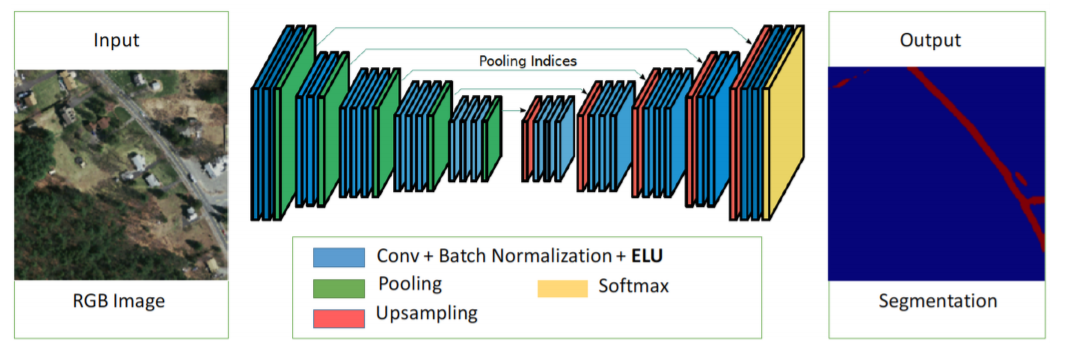

https://www.researchgate.net/publication/318125611_Road_Segmentation_of_Remotely-Sensed_Images_Using_Deep_Convolutional_Neural_Networks_with_Landscape_Metrics_and_Conditional_Random_Fields


# In order to save to train time, the upsampling part will only use 2 set of Conv2D + BatchNormalization + Relu for each layers.This architecture is quite similar to CNN, however, CNN is just downsize the image to hidden feature and connections then flatten and fully connected all the features to make a prediction. In this encoder and decoder schem, an upsample following downsample with concatenation to connect same level of encoder-decoder paired vector to a single vector to encode the feature information.

## Convolution {Conv2D + Batch Normalization + RELU activation}
### 1. Convolution layer is to use filters scan over the image matrix to extract convolved feature maps using 3x3 kernel matrix (filter). 0 padding will be used in this case to make sure the input and output before and after convolution is in line
### 2. Normalization layer is to prevent layer to layer internal covariate shift to maintain the input distribution
### 3. Activation layer use RELU {f(x) = max(0, x)} to save computaion power in hidden layer

## MaxPooling
### To divide a convolutional region into subregions and select a target representation (use max-pool to emphasize feature in this case) to reduce computation and increase robustness of the spatial feature using 2x2 filter and stride size of 2. Hence, the width and height will be shrinked to half.

## Upsampling
### 1. Conv2DTranspose which is the operation for upsampling with 0 padding around. Then the coresponding level of encoder and decoder will be in same shape, concatenate both of the encoder and decoder to form a single vector to represent the mask 

## Output
### Last but not least, the output layer will join and loop through original size of pixel to predict the possibility of a pixel should be existed or not with sigmoid {sigmoid function quite similar to perform binary classification with the chance of occurence}

In [103]:
def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([concat_tensor, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    return decoder

In [106]:
inputs = Input(shape=input_shape)
# 256*256

encoder0_pool, encoder0 = encoder_block(inputs, 32) #power(2,5) filters
# 128*128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) #power(2,6) filters
# 64*64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) #power(2,7) filters
# 32*32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) #power(2,8) filters
# 16*16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) #power(2,9) filters
# 8*8

center = conv_block(encoder4_pool, 1024) #power(2,10) filters
#8*8

decoder4 = decoder_block(center, encoder4, 512) #power(2,9) filters
# 16*16

decoder3 = decoder_block(decoder4, encoder3, 256) #power(2,8) filters
# 32*32

decoder2 = decoder_block(decoder3, encoder2, 128) #power(2,7) filters
# 64*64

decoder1 = decoder_block(decoder2, encoder1, 64) #power(2,6) filters
# 128*128

decoder0 = decoder_block(decoder1, encoder0, 32) #power(2,5) filters
# 256*256

outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

model = models.Model(inputs=[inputs], outputs=[outputs])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_109 (Conv2D)              (None, 256, 256, 32)  896         input_5[0][0]                    
____________________________________________________________________________________________________
batch_normalization_129 (BatchNo (None, 256, 256, 32)  128         conv2d_109[0][0]                 
____________________________________________________________________________________________________
activation_129 (Activation)      (None, 256, 256, 32)  0           batch_normalization_129[0][0]    
___________________________________________________________________________________________

In [107]:
'''
kaggle defined loss function, The Dice coefficient can be used to compare the pixel-wise agreement 
between a predicted segmentation and its corresponding ground truth
'''
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


In [109]:
'''
use a common optimizer and defiend loss
'''
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_loss])

In [112]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=int(np.ceil(train_size/ float(batch_size))),
    epochs=epochs,
    callbacks=[ModelCheckpoint('weights.best_model_batch5_epoch2.hdf5', monitor='dice_loss', save_best_only=True,save_weights_only = True)]
               )

Epoch 1/2


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


1018/1018 [==============================] - 11515s - loss: 0.1262 - dice_loss: 0.0661  
Epoch 2/2
1018/1018 [==============================] - 11949s - loss: 0.0443 - dice_loss: 0.0223  


In [123]:
model.save('model_batch5_epoch2_trained.h5')

In [138]:
def data_gen_test(data_dir, df_data, precess_batch_size, original_image_shape):
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, original_image_shape)
                imgs.append(resized_img)

            imgs = np.array(imgs)
            yield imgs

In [114]:
def test_gen_list(data_dir, df_data):
    imgs = []
    for id_ in df_data['img']:
        # images
        original_img = io.imread(data_dir + id_)
        resized_img = transform.resize(original_img, input_shape)
        imgs.append(resized_img)
        #imgs.append(np.array(imgs))
    return imgs

In [115]:
test_gen_sample = data_gen_test("D:Kaggle/holmusk/carvana-image-masking-challenge/train/", df_train_masks.iloc[:20], batch_size, input_shape)

In [116]:
'''
Visulization on prediction of training data
'''
steps = np.ceil(float(20) / float(batch_size))
y_predicted = model.predict_generator(
    test_gen_sample, 
    steps=steps
)

In [117]:
test_gen_lis = test_gen_list("D:Kaggle/holmusk/carvana-image-masking-challenge/train/", df_train_masks.iloc[:20])

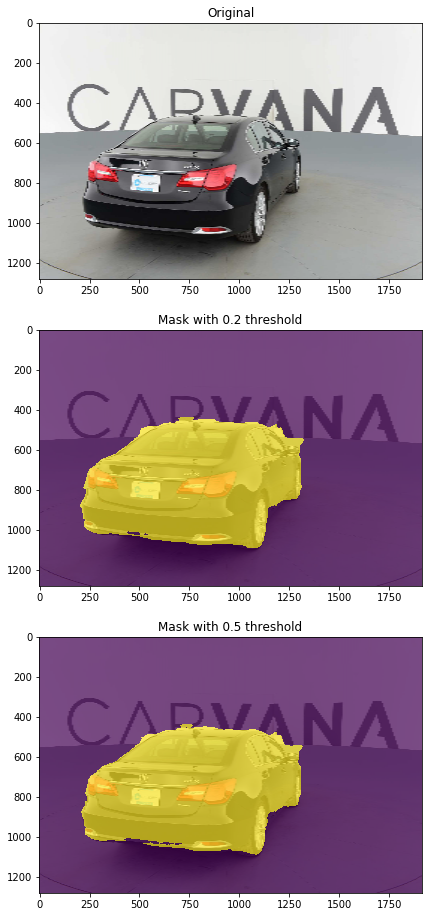

In [130]:
'''
data visulization
'''
fig=plt.figure(figsize=(16, 16))
id_=9
plt.subplot(3, 1, 1)
plt.title("Original")
plt.imshow(cv2.resize(test_gen_lis[id_],(1918,1280)))
plt.subplot(3, 1, 2)
plt.title("Mask with 0.2 threshold")
plt.imshow(cv2.resize(test_gen_lis[id_],(1918,1280)))
plt.imshow(((cv2.resize(y_predicted[id_],(1918,1280)))>0.2).astype(np.uint8),alpha=0.7)
plt.subplot(3, 1, 3)
plt.title("Mask with 0.5 threshold")
plt.imshow(cv2.resize(test_gen_lis[id_],(1918,1280)))
plt.imshow(((cv2.resize(y_predicted[id_],(1918,1280)))>0.5).astype(np.uint8),alpha=0.7)

In [139]:
'''
Prediction for the full set of test image
'''
test_gen = data_gen_test("D:Kaggle/holmusk/carvana-image-masking-challenge/test/", df_test, batch_size, input_shape)

# Out of Memory, so I didn't submit to the kaggle

In [141]:
steps = np.ceil(float(test_size) / float(batch_size))
y_predicted_full = model.predict_generator(
    test_gen, 
    steps=steps
)

C:\Users\User\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\User\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


MemoryError: 

In [ ]:
import pickle

In [ ]:
'''
Save 256*256 prediction matrix data
'''
with open('prediction_matrix_256_256.pickle', 'wb') as file:
    pickle.dump(y_predicted_full, file)

In [ ]:
'''
Convert 256*256 prediction to 1918*1280 which is the original image format
'''
list_prediction_matrix_original = []

In [ ]:
for id_ in range(test_size):
    list_prediction_matrix_original.append(((cv2.resize(y_predicted_full[id_],(1918,1280)))>0.5).astype(np.uint8).reshape(1918,1280))

In [ ]:
with open('prediction_matrix_1918_1280.pickle', 'wb') as file:
    pickle.dump(list_prediction_matrix_original, file)

In [ ]:
'''
Convert matrix to RLE
'''
def np_2d_img_to_str_rle(np_mask_img):
    np_mask_img_vec = np_mask_img.reshape(np_mask_img.shape[0] * np_mask_img.shape[1] )
    np_diff = np.diff(np_mask_img_vec)
    np_where_start = np.where(np_diff == 1)[0]
    np_where_end = np.where(np_diff == 255)[0] # -1 -> 255 in np.uint8, buffer-overflow
    start = np_where_start + 2
    end = np_where_end - start + 2
    list_output = ['%s %s' % (start[i], end[i]) for i in range(len(np_where_start))]
    str_output = ' '.join(list_output)
    return str_output

# For run like map-function
def mapfunc_np_2d_img_to_str_rle(np_img_mask_nx1280x1918):
    # Get RLE string from 1280 * 1918 image by N * 1280 * 1918 dataset
    return [np_2d_img_to_str_rle(np_img_mask_1280x1918) for np_img_mask_1280x1918 in np_img_mask_nx1280x1918]

In [ ]:
list_prediction_RLE = mapfunc_np_2d_img_to_str_rle(list_prediction_matrix_original)

In [ ]:
df_output = df_test.copy()

In [ ]:
df_output['rle_mask'] = list_prediction_RLE

In [ ]:
df_output.to_csv('submission_trial.csv', index=False)